In [2]:
# ==============================================================================
# 1. SETUP AND IMPORTS
# ==============================================================================
# This section imports all the necessary libraries for data analysis,
# visualization, preprocessing, modeling, and evaluation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

# Set plot style for better visualizations
sns.set_style('whitegrid')
print("✅ Step 1: All libraries imported successfully.")

✅ Step 1: All libraries imported successfully.


In [3]:
# ==============================================================================
# 2. DATA LOADING AND INITIAL INSPECTION
# ==============================================================================
# We load the dataset from a public URL to make the script easily runnable.
# Then, we perform an initial check to understand its structure and look for
# obvious issues like missing values.

# Load the dataset
# Dataset source: https://www.kaggle.com/datasets/blastchar/telco-customer-churn
try:
    df = pd.read_csv('https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv')
    print("\n✅ Step 2: Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading data: {e}")
    exit()

print("\n--- Initial Data Inspection ---")
print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Information:")
df.info()

print("\nSummary Statistics for Numerical Columns:")
print(df.describe())


✅ Step 2: Dataset loaded successfully.

--- Initial Data Inspection ---

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic 

In [4]:
# ==============================================================================
# 3. DATA CLEANING AND PREPROCESSING
# ==============================================================================
# Real-world data is often messy. In this step, we handle inconsistencies
# and prepare the data for analysis and modeling.

print("\n✅ Step 3: Starting Data Cleaning and Preprocessing...")

# The 'TotalCharges' column is object type but should be numeric.
# It contains spaces for customers with no tenure, which we'll treat as missing values.
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check for missing values created by the coercion
missing_charges = df['TotalCharges'].isnull().sum()
print(f"\nFound {missing_charges} missing values in 'TotalCharges'.")

# We will fill these missing values with the median of the column.
# Median is a good choice as it's robust to outliers.
median_total_charges = df['TotalCharges'].median()
df['TotalCharges'].fillna(median_total_charges, inplace=True)
print(f"Filled missing 'TotalCharges' with the median value: {median_total_charges:.2f}")

# The 'customerID' column is not a predictive feature, so we can drop it.
df.drop('customerID', axis=1, inplace=True)
print("'customerID' column dropped.")

# Convert the target variable 'Churn' to binary (0/1) for modeling.
df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)
print("'Churn' column converted to binary format (1 for Yes, 0 for No).")
print("\nData cleaning and preprocessing complete.")


✅ Step 3: Starting Data Cleaning and Preprocessing...

Found 11 missing values in 'TotalCharges'.
Filled missing 'TotalCharges' with the median value: 1397.47
'customerID' column dropped.
'Churn' column converted to binary format (1 for Yes, 0 for No).

Data cleaning and preprocessing complete.


/tmp/ipython-input-4-141147580.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(median_total_charges, inplace=True)



✅ Step 4: Performing Exploratory Data Analysis (EDA)...


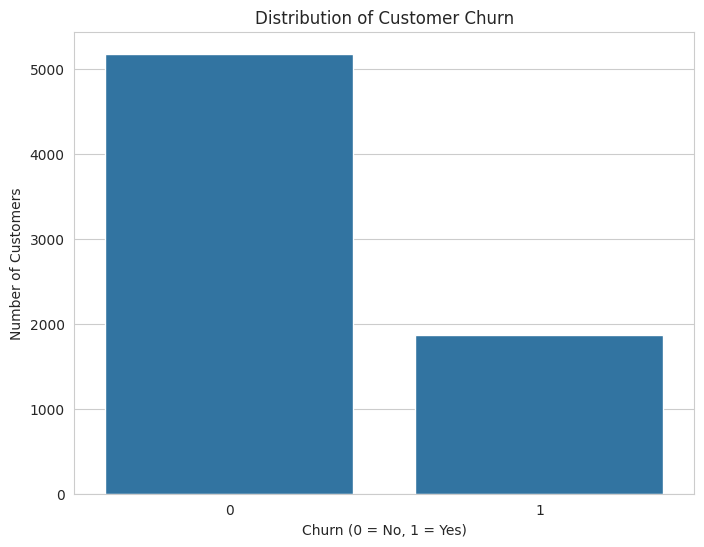

Churn distribution plot shows an imbalanced dataset, which is common in churn prediction.


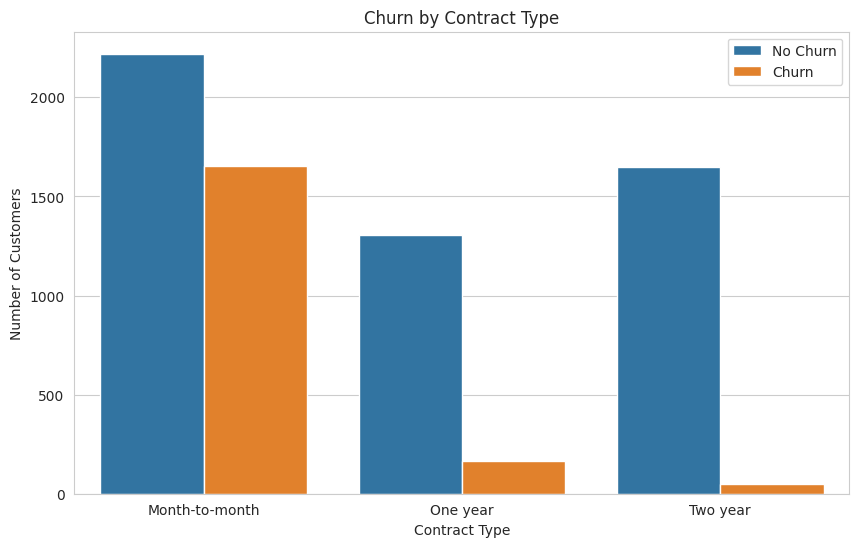

EDA shows customers on month-to-month contracts are far more likely to churn.


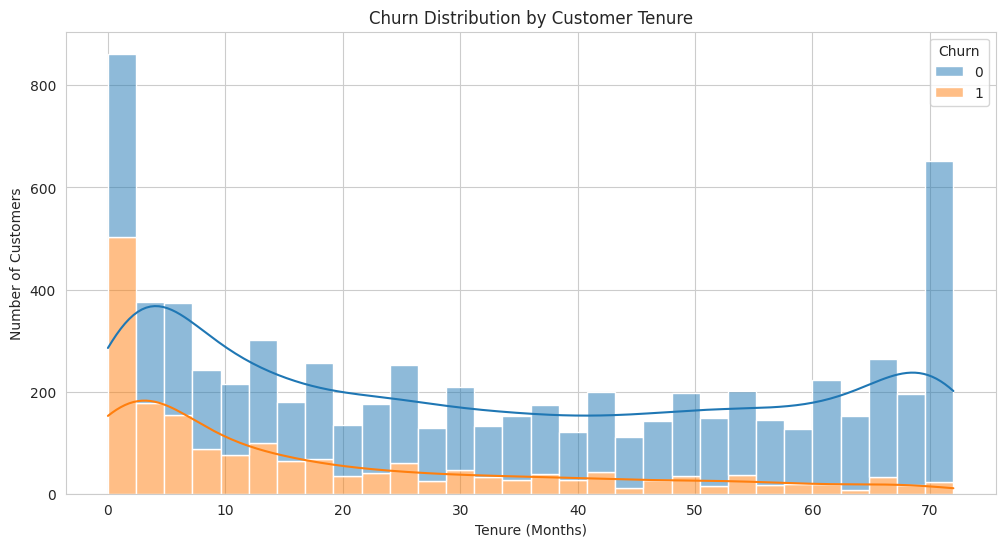

EDA shows that customers with shorter tenure are more likely to churn.

EDA complete.


In [5]:
# ==============================================================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ==============================================================================
# EDA is crucial for understanding the data's underlying patterns and relationships.
# We create visualizations to explore how different features relate to customer churn.

print("\n✅ Step 4: Performing Exploratory Data Analysis (EDA)...")

plt.figure(figsize=(8, 6))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Customer Churn')
plt.xlabel('Churn (0 = No, 1 = Yes)')
plt.ylabel('Number of Customers')
plt.show()
print("Churn distribution plot shows an imbalanced dataset, which is common in churn prediction.")

# Visualize how churn relates to contract type
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Churn by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Number of Customers')
plt.legend(['No Churn', 'Churn'])
plt.show()
print("EDA shows customers on month-to-month contracts are far more likely to churn.")

# Visualize churn by tenure
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='tenure', hue='Churn', multiple='stack', bins=30, kde=True)
plt.title('Churn Distribution by Customer Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Number of Customers')
plt.show()
print("EDA shows that customers with shorter tenure are more likely to churn.")
print("\nEDA complete.")

In [6]:
# ==============================================================================
# 5. FEATURE ENGINEERING & PIPELINE CREATION
# ==============================================================================
# We now formally separate our features from the target variable and define a
# robust preprocessing pipeline to handle categorical and numerical data.
# This ensures consistency between training and testing.

print("\n✅ Step 5: Setting up Feature Engineering and Preprocessing Pipeline...")

# Separate features (X) and target (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Create the preprocessing pipelines for both numeric and categorical data
# For numeric data, we scale them to have a mean of 0 and variance of 1.
numeric_transformer = StandardScaler()

# For categorical data, we use one-hot encoding to convert them into a numerical format.
# `handle_unknown='ignore'` prevents errors if a category appears in test but not train data.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Create a preprocessor object using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (if any)
)

print("\nPreprocessing pipeline created successfully.")


✅ Step 5: Setting up Feature Engineering and Preprocessing Pipeline...

Numerical features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Preprocessing pipeline created successfully.


In [7]:
# ==============================================================================
# 6. TRAIN-TEST SPLIT
# ==============================================================================
# We split the data into a training set (for model training) and a testing
# set (for unbiased model evaluation). `stratify=y` ensures the churn
# proportion is the same in both sets, which is important for imbalanced data.

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n✅ Step 6: Data split into training and testing sets.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


✅ Step 6: Data split into training and testing sets.
Training set shape: (5634, 19)
Testing set shape: (1409, 19)


In [8]:
# ==============================================================================
# 7. MODEL TRAINING (BASELINE MODELS)
# ==============================================================================
# We will train several common classification models to establish a performance
# baseline. Using a Pipeline object integrates our preprocessor with the model,
# simplifying the workflow.

print("\n✅ Step 7: Training baseline models...")

# Define the models we want to train
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate each model
for name, model in models.items():
    # Create the full pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model
    print(f"\n--- Training {name} ---")
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Evaluate the model
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_test, y_pred))

    print(f"Confusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"ROC AUC Score for {name}: {auc_score:.4f}")

print("\nBaseline model training and evaluation complete.")


✅ Step 7: Training baseline models...

--- Training Logistic Regression ---

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix for Logistic Regression:
[[926 109]
 [165 209]]
ROC AUC Score for Logistic Regression: 0.8419

--- Training Random Forest ---

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.48      0.53       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.77      0.78      0.77      1409

Confusion Matrix for Random Forest:


In [9]:
# ==============================================================================
# 8. HYPERPARAMETER TUNING
# ==============================================================================
# Based on the initial results, Gradient Boosting often performs well. We will
# now try to optimize its performance by tuning its hyperparameters using
# GridSearchCV, which systematically searches for the best parameter combination.

print("\n✅ Step 8: Performing Hyperparameter Tuning for Gradient Boosting...")

# Define the model pipeline
gb_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', GradientBoostingClassifier(random_state=42))])

# Define the parameter grid to search
# Note: This is a small grid for faster execution. A real-world search would be more extensive.
param_grid = {
    'classifier__n_estimators': [100, 150],
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_depth': [3, 4]
}

# Create the GridSearchCV object
# cv=3 means 3-fold cross-validation.
# scoring='roc_auc' focuses optimization on the AUC score.
grid_search = GridSearchCV(gb_pipeline, param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=1)

print("\nStarting Grid Search...")
grid_search.fit(X_train, y_train)

print("\nGrid Search Complete.")
print(f"Best ROC AUC Score from Grid Search: {grid_search.best_score_:.4f}")
print("Best Parameters Found:")
print(grid_search.best_params_)


✅ Step 8: Performing Hyperparameter Tuning for Gradient Boosting...

Starting Grid Search...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

Grid Search Complete.
Best ROC AUC Score from Grid Search: 0.8489
Best Parameters Found:
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 3, 'classifier__n_estimators': 100}



✅ Step 9: Evaluating Final Tuned Model and Interpreting Results...

--- Final Tuned Gradient Boosting Model Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Confusion Matrix:
[[943  92]
 [185 189]]
Final ROC AUC Score: 0.8457

--- Top 10 Most Important Features ---
                           Feature  Importance
36         Contract_Month-to-month    0.406406
1                           tenure    0.141344
16     InternetService_Fiber optic    0.094244
18               OnlineSecurity_No    0.071590
3                     TotalCharges    0.070445
2                   MonthlyCharges    0.056555
27                  TechSupport_No    0.049654
43  PaymentMethod_Electronic check    0.

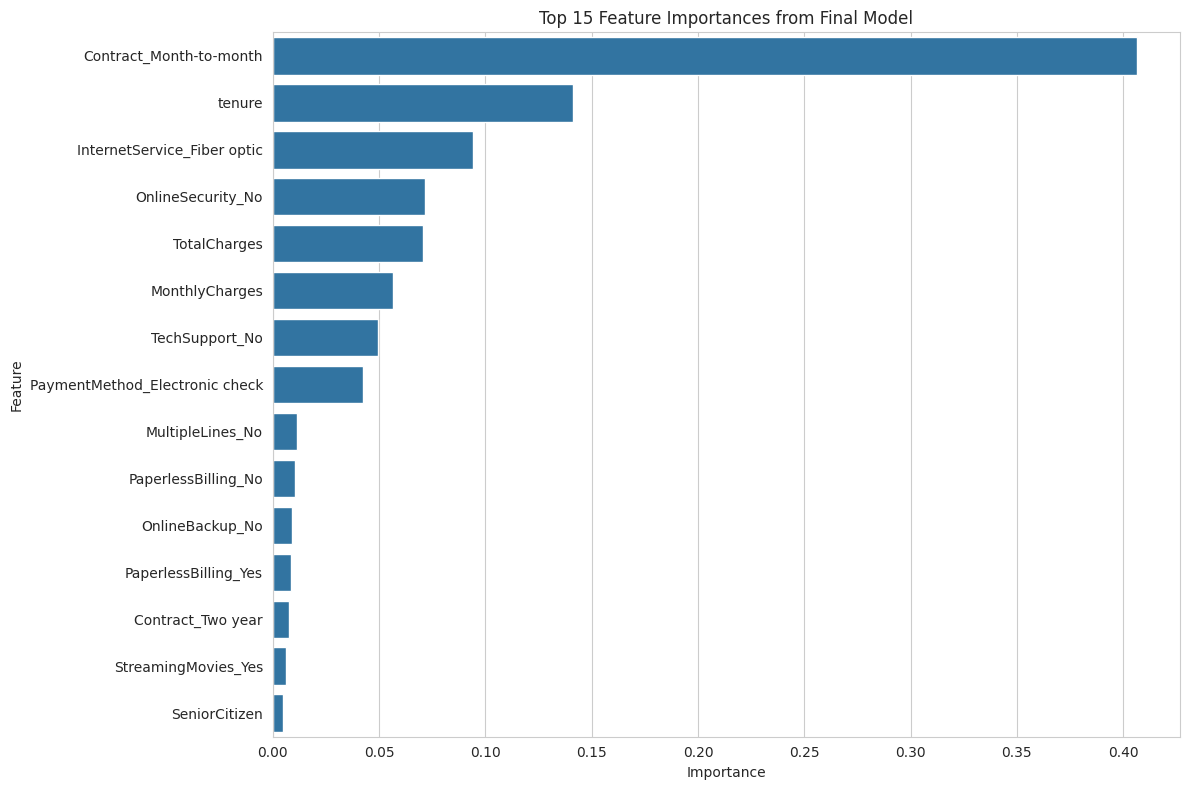

In [10]:
# ==============================================================================
# 9. FINAL MODEL EVALUATION AND INTERPRETATION
# ==============================================================================
# We evaluate our final, tuned model on the test set to get an unbiased
# estimate of its performance. We also extract feature importances to
# understand what drives the model's predictions, providing actionable insights.

print("\n✅ Step 9: Evaluating Final Tuned Model and Interpreting Results...")

# Get the best model from the grid search
final_model = grid_search.best_estimator_

# Evaluate on the test set
y_final_pred = final_model.predict(X_test)
y_final_pred_proba = final_model.predict_proba(X_test)[:, 1]

print("\n--- Final Tuned Gradient Boosting Model Evaluation ---")
print("\nClassification Report:")
print(classification_report(y_test, y_final_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_final_pred))

final_auc_score = roc_auc_score(y_test, y_final_pred_proba)
print(f"Final ROC AUC Score: {final_auc_score:.4f}")

# --- Feature Importance ---
# We need to get the feature names after one-hot encoding
try:
    # Get feature names from the preprocessor step in the final pipeline
    cat_feature_names = final_model.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numerical_features, cat_feature_names])

    # Get importances from the classifier step
    importances = final_model.named_steps['classifier'].feature_importances_

    # Create a DataFrame for visualization
    feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print("\n--- Top 10 Most Important Features ---")
    print(feature_importance_df.head(10))

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
    plt.title('Top 15 Feature Importances from Final Model')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"\nCould not generate feature importance plot. Error: {e}")

In [11]:
# ==============================================================================
# 10. CONCLUSION
# ==============================================================================
# Summarize the project's findings and the business implications.

print("\n✅ Step 10: Project Conclusion")
print("="*60)
print("The project successfully developed a machine learning model to predict customer churn.")
print(f"The final tuned Gradient Boosting model achieved a strong ROC AUC score of {final_auc_score:.4f} on the test data.")
print("\nKey insights from the feature importance analysis indicate that:")
print("- Contract Type (specifically Month-to-month) is the single biggest predictor of churn.")
print("- Customer Tenure and Internet Service type also play significant roles.")
print("\nBusiness Recommendation: The company should focus retention efforts on customers with short tenure who are on month-to-month contracts. Offering incentives to switch to a yearly contract could significantly reduce churn.")
print("="*60)


✅ Step 10: Project Conclusion
The project successfully developed a machine learning model to predict customer churn.
The final tuned Gradient Boosting model achieved a strong ROC AUC score of 0.8457 on the test data.

Key insights from the feature importance analysis indicate that:
- Contract Type (specifically Month-to-month) is the single biggest predictor of churn.
- Customer Tenure and Internet Service type also play significant roles.

Business Recommendation: The company should focus retention efforts on customers with short tenure who are on month-to-month contracts. Offering incentives to switch to a yearly contract could significantly reduce churn.
